<a href="https://colab.research.google.com/github/marquesbmc/Artificial-Intelligence/blob/main/TRAIN1_Final_Assignment_Semantic_Segmentation_2021_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Final Assignment - Semantic Segmentation**

Objective: Implement a U-Net Network for Semantic Segmentation

Dataset: ISPRS 2D Semantic Labeling Challenge (Vaihingen)

<figure>
<center>
<img src= 'https://drive.google.com/uc?export=view&id=19wmyEXtnTV8gMOn02FPeJ8JcVSKVOycH'/>
</figure>

In the code below the network was trained only with image Train1.

In the assignment you should use both Train1 and Train2 images to train. 

Notice that you will have to adapt the so that the network will take as imput an image concatenated with its DSM.




# **1. Import libraries**

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Jan 27 16:24:45 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from osgeo import ogr, gdal

from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Activation, Dense, Flatten, Dropout, concatenate, Conv2D, MaxPool2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# **2. Defining root folder**

In [ ]:
# root_path will be used to store trained models

from google.colab import drive
# mount your Google Drive
drive.mount('/content/drive', force_remount=True)

# adjust the path to the location where the models will be written / read
root_path = '/content/drive/My Drive/Colab Notebooks/'

Mounted at /content/drive


# **3. Loading the data**

In [ ]:
# Downloading the dataset and unpacking it.
# 6 files: Test_Image.tif, Test_DSM.tif, Test_Reference.tif, Train1_Image.tif, Train1_DSM.tif, Train1_Reference.tif, Train2_Image.tif, Train2_DSM.tif, Train2_Reference.tif

!wget https://github.com/gilson-costa/files/raw/main/Images_Semantic_Segmentatio_Assignment.part1.rar
!wget https://github.com/gilson-costa/files/raw/main/Images_Semantic_Segmentatio_Assignment.part2.rar
!wget https://github.com/gilson-costa/files/raw/main/Images_Semantic_Segmentatio_Assignment.part3.rar
!unrar e Images_Semantic_Segmentatio_Assignment.part1.rar


--2022-01-27 16:25:51--  https://github.com/gilson-costa/files/raw/main/Images_Semantic_Segmentatio_Assignment.part1.rar
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/gilson-costa/files/main/Images_Semantic_Segmentatio_Assignment.part1.rar [following]
--2022-01-27 16:25:52--  https://raw.githubusercontent.com/gilson-costa/files/main/Images_Semantic_Segmentatio_Assignment.part1.rar
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25165824 (24M) [application/octet-stream]
Saving to: ‘Images_Semantic_Segmentatio_Assignment.part1.rar’

Images_Semantic_Seg 100%[===================>]  24.00M  --.-KB/

In [ ]:
# Listing the contents of the virtual machine.
!ls -l

total 226224
drwx------ 5 root root     4096 Jan 27 16:25 drive
-rw-r--r-- 1 root root 25165824 Jan 27 16:25 Images_Semantic_Segmentatio_Assignment.part1.rar
-rw-r--r-- 1 root root 25165824 Jan 27 16:25 Images_Semantic_Segmentatio_Assignment.part2.rar
-rw-r--r-- 1 root root  9414015 Jan 27 16:25 Images_Semantic_Segmentatio_Assignment.part3.rar
drwxr-xr-x 1 root root     4096 Jan  7 14:33 sample_data
-rw-r--r-- 1 root root 28852100 Aug 19  2014 Test_DSM.tif
-rw-r--r-- 1 root root 21789756 Nov  1  2013 Test_Image.tif
-rw-r--r-- 1 root root 22326104 Apr 28  2014 Test_Reference.tif
-rw-r--r-- 1 root root 19707152 Aug 19  2014 Train1_DSM.tif
-rw-r--r-- 1 root root 14870332 Nov  1  2013 Train1_Image.tif
-rw-r--r-- 1 root root 15259952 Apr 28  2014 Train1_Reference.tif
-rw-r--r-- 1 root root 19398356 Aug 19  2014 Train2_DSM.tif
-rw-r--r-- 1 root root 14643100 Nov  1  2013 Train2_Image.tif
-rw-r--r-- 1 root root 15036852 Apr 28  2014 Train2_Reference.tif


In [ ]:
### Conhecendo arquivo DSM

# capturar dados
gdal_dataset = gdal.Open('Train1_DSM.tif' )

#Total de banda
print ("Total de banda : ", gdal_dataset.RasterCount)

# 1 unica banda
gdal_band = gdal_dataset.GetRasterBand(1)

# transformar np array
gdal_arr = gdal_band.ReadAsArray()

#Dimensão
print ("Dimensão : ",gdal_arr.shape)


Total de banda :  1
Dimensão :  (2565, 1919)


In [ ]:
# Functions

def load_tiff_image(image):
  print (image)
  gdal_header = gdal.Open(image)
  img_gdal = gdal_header.ReadAsArray()
  img = np.transpose(img_gdal, (1,2,0))
  return img

def normalization(image):
  image_reshaped = image.reshape((image.shape[0]*image.shape[1]),image.shape[2])
  scaler = MinMaxScaler(feature_range=(0,1))
  scaler = scaler.fit(image_reshaped)
  image_normalized_ = scaler.fit_transform(image_reshaped)
  image_normalized = image_normalized_.reshape(image.shape[0],image.shape[1],image.shape[2])
  return image_normalized

def load_normalization_dsm(image):
  print(image)
  gdal_header = gdal.Open(image)
  dsm_gdal = gdal_header.ReadAsArray()
  dsm_normalized = (dsm_gdal - np.min(dsm_gdal)) / (np.max(dsm_gdal) - np.min(dsm_gdal))
  return dsm_normalized

In [ ]:
# carregando e normalizando as imagens. - fazendo para train1 e train2

## Train 1
print('TRAIN1: ')
reference_train1 = load_tiff_image('Train1_Reference.tif')
print(reference_train1.shape)
image_train1 = load_tiff_image('Train1_Image.tif')
# Normalizes training image (pixel values from 0 to 1)
image_train1 = normalization(image_train1)
print(image_train1.shape, '\n')

## Train 2
print('TRAIN2: ')
reference_train2 = load_tiff_image('Train2_Reference.tif')
print(reference_train2.shape)
image_train2 = load_tiff_image('Train2_Image.tif')
# Normalizes training image (pixel values from 0 to 1)
image_train2 = normalization(image_train2)
print(image_train2.shape, '\n')

## Test
print('TEST: ') 
reference_test = load_tiff_image('Test_Reference.tif')
print(reference_test.shape)
image_test = load_tiff_image('Test_Image.tif')
image_test = normalization(image_test)
print(image_test.shape)
dsm_test = load_normalization_dsm('Test_DSM.tif')
print(dsm_test.shape, '\n')

## Imagem DSM 
print('DSM:')
dsm_train1 = load_normalization_dsm('Train1_DSM.tif')
print(dsm_train1.shape)
dsm_train2 = load_normalization_dsm('Train2_DSM.tif')
print(dsm_train2.shape)


TRAIN1: 
Train1_Reference.tif
(2565, 1919, 3)
Train1_Image.tif
(2565, 1919, 3) 

TRAIN2: 
Train2_Reference.tif
(2546, 1903, 3)
Train2_Image.tif
(2546, 1903, 3) 

TEST: 
Test_Reference.tif
(2558, 2818, 3)
Test_Image.tif
(2558, 2818, 3)
Test_DSM.tif
(2558, 2818) 

DSM:
Train1_DSM.tif
(2565, 1919)
Train2_DSM.tif
(2546, 1903)


In [ ]:
# Config image train
image_train = image_train1
reference_train = reference_train1

# **4. Creating labeled images from references**

In [ ]:
# Defining number of classes and class indices in relation to reference images (RGB)

num_classes = 6
color2label = {
    (255, 255, 255) : 0,  # Impervious surfaces
    (0,   255, 255) : 1,  # Low vegetation
    (0,     0, 255) : 2,  # Building
    (0,   255,   0) : 3,  # Tree
    (255, 255,   0) : 4   # Car
}

def create_label_image(rgb_image):
  W = np.power(256, [[0],[1],[2]])
  img_index = rgb_image.dot(W).squeeze(-1) 
  values = np.unique(img_index)
  label_image = np.zeros(img_index.shape)
  for i, c in enumerate(values):
    try:
      label_image[img_index==c] = color2label[tuple(rgb_image[img_index==c][0])] 
    except:
      pass
  return label_image

In [ ]:
# Tranforming regerence RGB images into label images

labels_train = create_label_image(reference_train)
print(labels_train.shape)
labels_test = create_label_image(reference_test)
print(labels_test.shape)

(2565, 1919)
(2558, 2818)


# **5. Extracting image patches for training**

In [ ]:
# Constants and functions

# patch_size defines the measures (spatial dimensions) of the patch.
# Working with square patches (H = W). Therefore, a scalar variable is enough.
patch_size = 256

# patch_stride determine the position of the next patch.
# A patch_stride smaller than the spatial dimension of the patch determines an overlapping.
# 25% ​​overlap between patches.
patch_stride = patch_size - (patch_size // 4)

# channels of the image/patches to be segmented


#adicionar um if reference_train1.shape[2]
#image_channels = 3 #<################################# dim +1
image_channels = image_train.shape[2]

# shape of the input to the network (training)
input_shape = (patch_size, patch_size, image_channels)

# Function: extract_patches
# -------------------------
# Extract patches from the original and reference image
#
# Input parameters:
#   image      = array containing the original image (h,w,c)
#   reference  = array containing the reference image (h,w,c)
#   patch_size = patch size (scalar). The shape of the patch is square.
#   stride     = displacement to be applied.
#   border_patches = include patches overlaping image borders
#
# Returns: 
#   A, B = List containing the patches for the input image (A) and respective reference (B).
#
def extract_patches(image, reference, patch_size, stride, border_patches=False):
    print("Image dimensions:", image.shape)
    print("Reference dimensions:", reference.shape)

    patch_img = []
    patch_ref = []

    h = image.shape[0] // stride
    w = image.shape[1] // stride

    for m in range(0, h):
        for n in range(0, w):
            #print('M %d, N %d, start %d finish %d , start %d finish %d' % (m, n, m*stride , m*stride+patch_size, n*stride, n*stride+patch_size) )
            if ( (m*stride+patch_size <= image.shape[0]) and (n*stride+patch_size <= image.shape[1]) ):
                patch_img.append( image[m*stride:m*stride+patch_size,n*stride:n*stride+patch_size,:] )
                patch_ref.append( reference[m*stride:m*stride+patch_size,n*stride:n*stride+patch_size] )
            elif border_patches:
                border_patch_img = np.zeros((patch_size,patch_size,image_channels))
                border_patch_ref = np.zeros((patch_size,patch_size))
                if (m*stride+patch_size > image.shape[0]):
                  border_mmax = patch_size-(m*stride+patch_size-image.shape[0])
                else:
                  border_mmax = patch_size-1
                if (n*stride+patch_size > image.shape[1]):
                  border_nmax = patch_size-(n*stride+patch_size-image.shape[1])
                else:
                  border_nmax = patch_size-1

                border_patch_img[0:border_mmax,0:border_nmax,:] = image[m*stride:m*stride+border_mmax,n*stride:n*stride+border_nmax,:]
                border_patch_ref[0:border_mmax,0:border_nmax] = reference[m*stride:m*stride+border_mmax,n*stride:n*stride+border_nmax]
                patch_img.append( border_patch_img )
                patch_ref.append( border_patch_ref )
       
    return np.array(patch_img), np.array(patch_ref)


In [ ]:
# Extracting training patches

x_patches, y_patches = extract_patches(image_train, labels_train, patch_size, patch_stride) #<#################

# Transform y_patches, shape (N, H, W) into shape (N, H, W, C). Necessary for data agumentation.
y_patches = np.expand_dims(y_patches, 3)

print( "Number of patches: %d %s " % ( x_patches.shape[0], x_patches.shape[1:] ) )
print( "Number of labeled references: %d %s " % ( y_patches.shape[0], y_patches.shape[1:] ) )

Image dimensions: (2565, 1919, 3)
Reference dimensions: (2565, 1919)
Number of patches: 117 (256, 256, 3) 
Number of labeled references: 117 (256, 256, 1) 


# **6. Separating training and validation patches**

In [ ]:
# Defining the percentage of the training set to be used as validation
valid_percent = 0.2

# Calculating the boundary (index) between training set and validation.
# The premise is always that X and Y have the same number of elements.
limit = len(x_patches) - int( len(x_patches)*valid_percent )

# Building a list of indexes from 0 to N, where N corresponds to the number of images (patches).
indexes = [i for i in range(x_patches.shape[0])]

# Generating randomness in the list
import random
random.shuffle(indexes)

# Indexes of the images that will be used for training
indexes_for_train = indexes[:limit]
# ndexes of the images that will be used for validation
indexes_for_valid = indexes[limit:]

# Training set
x_train = x_patches[indexes_for_train]
y_train = y_patches[indexes_for_train]

# Validation set
x_valid = x_patches[indexes_for_valid]
y_valid = y_patches[indexes_for_valid]

print( "Número de imagens no conjunto de treinamento: %d " % ( len(x_train) ) )
print( "Número de imagens no conjunto de validação: %d " % ( len(x_valid) ) )

# Freeing up memory
x_patches = 0
y_patches = 0

Número de imagens no conjunto de treinamento: 94 
Número de imagens no conjunto de validação: 23 


# **7. Data augmentation**

In [ ]:
# Setting data augmentation tranformations and creating data generators

# Only rotations by 90 degrees
def orthogonal_rot(image):
    return np.rot90(image, np.random.choice([-1, 0, 1]))

# Tranformations for image patches
datagen_args_x = dict(
        # rotation_range=90, # rotation
        # width_shift_range=0.15, # horizontal shift
        # height_shift_range=0.15, # vertical shift
        # zoom_range=0.25, # zoom
        preprocessing_function=orthogonal_rot,
        horizontal_flip=True, # horizontal flip
        vertical_flip=True, # vertical flip
        # brightness_range=[0.8,1.2], # brightness
        fill_mode='constant',
        cval=0
)

# Transformations for reference patches
datagen_args_y = dict(
        # rotation_range=90, # rotation
        # width_shift_range=0.15, # horizontal shift
        # height_shift_range=0.15, # vertical shift
        # zoom_range=0.25, # zoom
        preprocessing_function=orthogonal_rot,
        horizontal_flip=True, # horizontal flip
        vertical_flip=True, # vertical flip
        fill_mode='constant',
        cval=0
)

# Its necessary to provide the same seed and kwargs to the flow method (images and references)
seed = 1
x_datagen = ImageDataGenerator(**datagen_args_x)
y_datagen = ImageDataGenerator(**datagen_args_y)

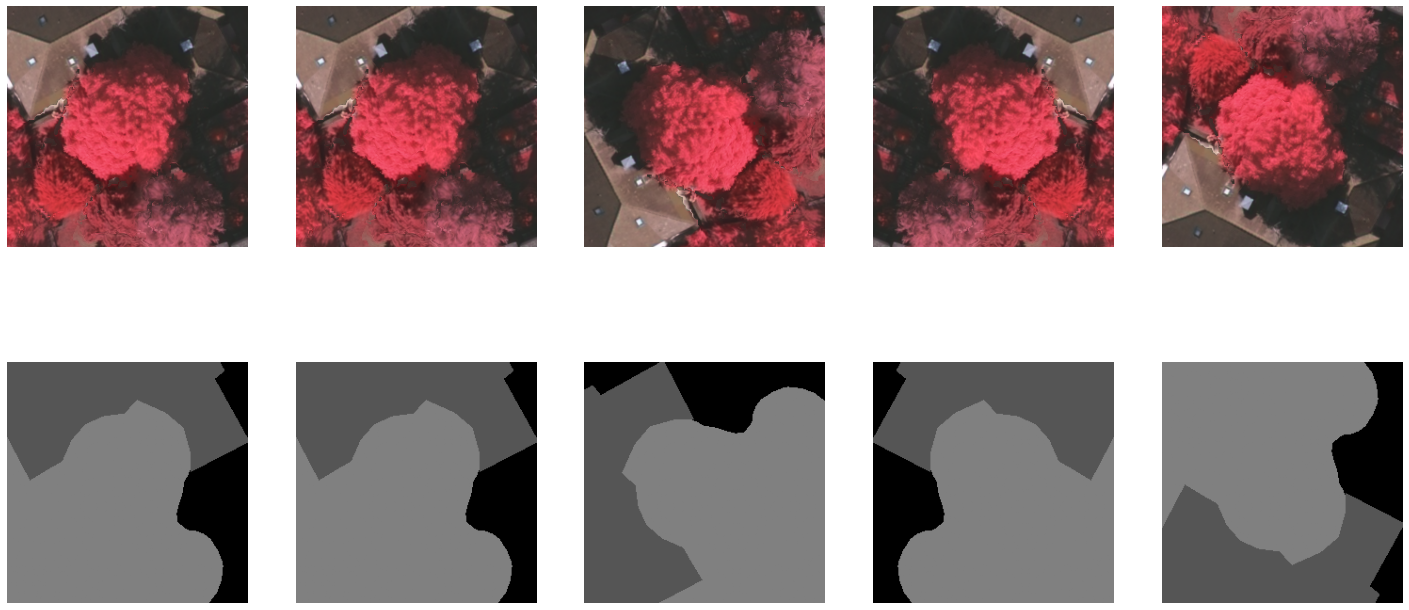

In [ ]:
# Example of Data Augmentation for an arbitrary patch

show_index = 25

x_patch = np.expand_dims( x_train[show_index], 0 )
y_patch = np.expand_dims( y_train[show_index], 0 )

x_iterator = x_datagen.flow(x_patch, seed=seed)
y_iterator = y_datagen.flow(y_patch, seed=seed)

data_iterator = next( zip( x_iterator, y_iterator ) )

nrows = 2
ncols = 5
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(25,12))

# generating transformed images
for j in range(ncols):
    data_iterator = next( zip( x_iterator, y_iterator ) )
    ax[0][j].axis('off')
    ax[0][j].imshow(data_iterator[0][0])
    ax[1][j].axis('off')
    ax[1][j].imshow(data_iterator[1][0,:,:,0], cmap='gray', vmin=0, vmax=num_classes )



# **8. Building the CNN model**

In [ ]:
# Defining the structure of the CNN

def unet(input_shape, n_classes):
    # U-Net architecture

    input_img = Input(input_shape)

    # Define the layers here...
    
     # Contract stage
    f1 = 64
    dp = 0.5

    b1conv1 = Conv2D(f1 , (3 , 3) , activation='relu' , padding='same', name = 'b1conv1')(input_img)
    b1conv2 = Conv2D(f1 , (3 , 3) , activation='relu' , padding='same', name = 'b1conv2')(b1conv1)

    pool1 = MaxPool2D((2 , 2), name = 'pooling1')(b1conv2)

    b2conv1 = Conv2D(f1*2 , (3 , 3) , activation='relu' , padding='same', name = 'b2conv1')(pool1)
    b2conv2 = Conv2D(f1*2 , (3 , 3) , activation='relu' , padding='same', name = 'b2conv2')(b2conv1)

    pool2 = MaxPool2D((2 , 2), name = 'pooling2')(b2conv2)
    
    b3conv1 = Conv2D(f1*4 , (3 , 3) , activation='relu' , padding='same', name = 'b3conv1')(pool2)
    b3conv2 = Conv2D(f1*4 , (3 , 3) , activation='relu' , padding='same', name = 'b3conv2')(b3conv1)
    
    pool3 = MaxPool2D((2 , 2), name = 'pooling3')(b3conv2)
    
    b4conv1 = Conv2D(f1*8 , (3 , 3) , activation='relu' , padding='same', name = 'b4conv1')(pool3)
    b4conv2 = Conv2D(f1*8 , (3 , 3) , activation='relu' , padding='same', name = 'b4conv2')(b4conv1)
    drop4 = Dropout(dp)(b4conv2)
    pool4 = MaxPool2D((2 , 2), name = 'pooling4')(drop4)
    
    b5conv1 = Conv2D(f1*16 , (3 , 3) , activation='relu' , padding='same', name = 'b5conv1')(pool4)
    b5conv2 = Conv2D(f1*16 , (3 , 3) , activation='relu' , padding='same', name = 'b5conv2')(b5conv1)
    drop5 = Dropout(dp)(b5conv2)

    # Expansion stage
    
    upsample6 = Conv2DTranspose(f1*8, (3 , 3), activation = 'relu', padding = 'same', name = 'upsampling1')(UpSampling2D(size = (2,2))(drop5))
    concat6 = concatenate( [drop4,upsample6] )
    b6conv1 = Conv2D(f1*8 , (3 , 3) , activation='relu' , padding='same', name = 'b6conv1')(concat6)
    b6conv2 = Conv2D(f1*8 , (3 , 3) , activation='relu' , padding='same', name = 'b6conv2')(b6conv1)

    upsample7 = Conv2DTranspose(f1*4, (3 , 3), activation = 'relu', padding = 'same', name = 'upsampling2')(UpSampling2D(size = (2,2))(b6conv2))
    concat7 = concatenate( [upsample7,b3conv2] )
    b7conv1 = Conv2D(f1*4 , (3 , 3) , activation='relu' , padding='same', name = 'b7conv1')(concat7)
    b7conv2 = Conv2D(f1*4 , (3 , 3) , activation='relu' , padding='same', name = 'b7conv2')(b7conv1)

    
    upsample8 = Conv2DTranspose(f1*2, (3 , 3), activation = 'relu', padding = 'same', name = 'upsampling3')(UpSampling2D(size = (2,2))(b7conv2))
    concat8 = concatenate( [upsample8,b2conv2] )
    b8conv1 = Conv2D(f1*2 , (3 , 3) , activation='relu' , padding='same', name = 'b8conv1')(concat8)
    b8conv2 = Conv2D(f1*2 , (3 , 3) , activation='relu' , padding='same', name = 'b8conv2')(b8conv1)

    upsample9 = Conv2DTranspose(f1, (3 , 3), activation = 'relu', padding = 'same', name = 'upsampling4')(UpSampling2D(size = (2,2))(b8conv2))
    concat9 = concatenate( [upsample9,b1conv2] )
    b9conv1 = Conv2D(f1 , (3 , 3) , activation='relu' , padding='same', name = 'b9conv1')(concat9)
    
    b9conv2 = Conv2D(f1 , (3 , 3) , activation='relu' , padding='same', name = 'b9conv2')(b9conv1)
    b9conv3 = Conv2D(f1 , (3 , 3) , activation='relu' , padding='same', name = 'b9conv3')(b9conv2)
   
    # Output segmentation
    b10conv1 = Conv2D(f1 , (3 , 3) , activation='relu' , padding='same', name = 'b9conv4')(b9conv3)

    output = Conv2D(n_classes,(1,1), activation = 'softmax')(b10conv1)
    return Model(inputs = input_img, outputs = output, name='U-Net')

In [ ]:
# Building the model

model = unet(input_shape, num_classes)
model.summary()


Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 b1conv1 (Conv2D)               (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 b1conv2 (Conv2D)               (None, 256, 256, 64  36928       ['b1conv1[0][0]']                
                                )                                                             

#Deeplabv3plus

In [ ]:


from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input

from tensorflow.keras.layers import AveragePooling2D, GlobalAveragePooling2D, UpSampling2D, Reshape, Dense

from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
import tensorflow as tf

In [ ]:
def SqueezeAndExcite(inputs, ratio=8):
    init = inputs
    filters = init.shape[-1]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)
    x = init * se
    return x

In [ ]:
def ASPP(inputs):
    """ Image Pooling """
    shape = inputs.shape
    y1 = AveragePooling2D(pool_size=(shape[1], shape[2]))(inputs)
    y1 = Conv2D(256, 1, padding="same", use_bias=False)(y1)
    y1 = Dropout(0.2)(y1)
    y1 = BatchNormalization()(y1)
    y1 = Activation("relu")(y1)
    y1 = UpSampling2D((shape[1], shape[2]), interpolation="bilinear")(y1)

    """ 1x1 conv """
    y2 = Conv2D(256, 1, padding="same", use_bias=False)(inputs)
    y2 = Dropout(0.2)(y2)
    y2 = BatchNormalization()(y2)
    y2 = Activation("relu")(y2)

    """ 3x3 conv rate=6 """
    y3 = Conv2D(256, 3, padding="same", use_bias=False, dilation_rate=6)(inputs)
    y3 = Dropout(0.2)(y3)
    y3 = BatchNormalization()(y3)
    y3 = Activation("relu")(y3)

    """ 3x3 conv rate=12 """
    y4 = Conv2D(256, 3, padding="same", use_bias=False, dilation_rate=12)(inputs)
    y4 = Dropout(0.2)(y4)
    y4 = BatchNormalization()(y4)
    y4 = Activation("relu")(y4)

    """ 3x3 conv rate=18 """
    y5 = Conv2D(256, 3, padding="same", use_bias=False, dilation_rate=18)(inputs)
    y5 = Dropout(0.2)(y5)
    y5 = BatchNormalization()(y5)
    y5 = Activation("relu")(y5)

    y = Concatenate()([y1, y2, y3, y4, y5])
    y = Conv2D(256, 1, padding="same", use_bias=False)(y)
    y = Dropout(0.2)(y)
    y = BatchNormalization()(y)
    y = Activation("relu")(y)

    return y

In [ ]:
#deeplabv3plus

shape =input_shape
def deeplabv3_plus(shape):

    """ Input """
    inputs = Input(shape)

    """ Encoder """
    encoder = ResNet50(weights="imagenet", include_top=False, input_tensor=inputs)
    
    image_features = encoder.get_layer("conv4_block6_out").output
    x_a = ASPP(image_features)
    x_a = UpSampling2D((4, 4), interpolation="bilinear")(x_a)

    x_b = encoder.get_layer("conv2_block2_out").output
    x_b = Conv2D(filters=48, kernel_size=1, padding='same', use_bias=False)(x_b)
    x_b = Dropout(0.2)(x_b)
    x_b = BatchNormalization()(x_b)
    x_b = Activation('relu')(x_b)
    
    x = Concatenate()([x_a, x_b])
    x = SqueezeAndExcite(x)

    x = Conv2D(filters=256, kernel_size=3, padding='same', use_bias=False)(x)
    x = Dropout(0.2)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=256, kernel_size=3, padding='same', use_bias=False)(x)
    x = Dropout(0.2)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SqueezeAndExcite(x)

    x = UpSampling2D((4, 4), interpolation="bilinear")(x)
    x = Conv2D(1, 1)(x)
    x = Activation("sigmoid")(x)
   

    model = Model(inputs, x)
    return model

In [ ]:
print(input_shape)
modelDeeplabv3_plus = deeplabv3_plus(input_shape)
modelDeeplabv3_plus.summary()


(256, 256, 3)
94781440/94765736 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
               

# **9. Functions for training the network**

In [ ]:
# Functions for training

def set_number_of_batches(qt_train_samples, qt_valid_samples, batch_size, data_augmentation, number_samples_for_generator=6):
    if data_augmentation:
        train_batchs_qtd = qt_train_samples//number_samples_for_generator
        valid_batchs_qtd = qt_valid_samples//number_samples_for_generator
    else:
        train_batchs_qtd = qt_train_samples//batch_size
        valid_batchs_qtd = qt_valid_samples//batch_size

    return train_batchs_qtd, valid_batchs_qtd

def get_batch_samples(x, y, batch, batch_size, data_augmentation, number_samples_for_generator):
    if data_augmentation:
        x_batch = x[batch * number_samples_for_generator : (batch + 1) * number_samples_for_generator, : , : , :]
        y_batch = y[batch * number_samples_for_generator : (batch + 1) * number_samples_for_generator, : , : , :]

        x_iterator = x_datagen.flow(x_batch, seed=batch)
        y_iterator = y_datagen.flow(y_batch, seed=batch)

        x_batch = np.array([next(x_iterator)[0] for _ in range(batch_size)])
        y_batch = np.array([next(y_iterator)[0] for _ in range(batch_size)])
    else:
        x_batch = x[batch * batch_size : (batch + 1) * batch_size, : , : , :]
        y_batch = y[batch * batch_size : (batch + 1) * batch_size, : , : , :]

    return x_batch, y_batch

def train_unet(net, x_train, y_train, x_valid, y_valid, batch_size, epochs, early_stopping_epochs, early_stopping_delta, filepath, filename, data_augmentation=False, number_samples_for_generator=1):
    print('Start the training...')

    # calculating number of batches
    train_batchs_qtd, valid_batchs_qtd = set_number_of_batches(x_train.shape[0], x_valid.shape[0], batch_size, data_augmentation, number_samples_for_generator)
  
    history_train = []
    history_valid = []
    valid_loss_best_model = float('inf')
    no_improvement_count = 0

    for epoch in range(epochs):
        print('Start epoch ... %d ' %(epoch) )
        # shuffle train set
        x_train, y_train = shuffle(x_train , y_train, random_state = 0)

        # TRAINING
        train_loss = np.zeros((1 , 2))
        # mini batches strategy
        for  batch in range(train_batchs_qtd):
            print('Start batch ... %d ' %(batch) )
            x_train_batch, y_train_batch = get_batch_samples(x_train, y_train, batch, batch_size, data_augmentation, number_samples_for_generator)
            train_loss = train_loss + net.train_on_batch(x_train_batch, y_train_batch)

        # Estimating the loss in the training set
        train_loss = train_loss/train_batchs_qtd

        # VALIDATING
        valid_loss = np.zeros((1 , 2))
        # Evaluating the network (model) with the validation set
        for  batch in range(valid_batchs_qtd):
            x_valid_batch, y_valid_batch = get_batch_samples(x_valid, y_valid, batch, batch_size, data_augmentation, number_samples_for_generator)
            print('valid_loss1: ',valid_loss)
            valid_loss = valid_loss + net.test_on_batch(x_valid_batch, y_valid_batch)
            print('valid_loss2: ',valid_loss)
            print('x_valid_batch: ',x_valid_batch)
            print('y_valid_batch: ',y_valid_batch)
            print('x_valid_batch.shape: ',x_valid_batch.shape)
            print('y_valid_batch.shape: ',y_valid_batch.shape)
            print(net.test_on_batch(x_valid_batch, y_valid_batch))

        # Estimating the loss in the validation set
        valid_loss = valid_loss/valid_batchs_qtd

        # Showing the results.
        print("%d [training loss: %f , Train acc.: %.2f%%][Test loss: %f , Test acc.:%.2f%%]" %(epoch , train_loss[0 , 0], 100*train_loss[0 , 1] , valid_loss[0 , 0] , 100 * valid_loss[0 , 1]))
        history_train.append( train_loss )
        history_valid.append( valid_loss )

        # Early Stopping
        if (1-(valid_loss[0 , 0]/valid_loss_best_model)) < early_stopping_delta:
            if no_improvement_count+1 >= early_stopping_epochs:
                print('Early Stopping reached')
                break
            else:
                no_improvement_count = no_improvement_count+1
        else:
            valid_loss_best_model = valid_loss[0 , 0]
            no_improvement_count = 0

            # Saving best model  
            print("Saving the model...")
            net.save(filepath+filename+'.h5')

    return [ history_train, history_valid ]


# **10. Defining hyperparameters**

In [ ]:
# Defining hyperparameters for training Unet


#batch_size = 20
batch_size = 30
epochs = 200

# Fixed class weights: [Impervious surfaces, Low vegetation, Building, Tree, Car]
#class_weights = [0.10, 0.10, 0.10 , 0.10, 2.00]x
#class_weights = [0.8, 0.8, 0.9 , 0.5, 9.00]x
#class_weights = [0.7, 0.7, 0.8 , 0.4, 5.00]x
#class_weights = [0.3, 0.3, 0.5 , 0.6, 9.00]x

# Early stoping parameters
early_stopping_epochs = 10
early_stopping_delta = 0.0001 # delta improvement equivalent to 0.01%

data_augmentation = True
number_samples_for_generator = 2

# optimizer
adam = Adam(learning_rate = 0.0001 , beta_1=0.9)







In [ ]:
# Defining hyperparameters for training

batch_size = 16
epochs = 500

# Fixed class weights: [Impervious surfaces, Low vegetation, Building, Tree, Car]
#class_weights = [0.10, 0.10, 0.10 , 0.10, 2.00]x
#class_weights = [0.8, 0.8, 0.9 , 0.5, 9.00]x
#class_weights = [0.7, 0.7, 0.8 , 0.4, 5.00]x
#class_weights = [0.3, 0.3, 0.5 , 0.6, 9.00]x
class_weights = [0.8, 0.8, 0.9 , 0.5, 11.00]


# Early stoping parameters
early_stopping_epochs = 10
early_stopping_delta = 0.0001 # delta improvement equivalent to 0.01%
  
data_augmentation = True
number_samples_for_generator = 2

# optimizer
adam = Adam(learning_rate = 0.0001 , beta_1=0.9)

# **11.a Start training**

In [ ]:
# Compile the model Unet
model.compile(loss = "sparse_categorical_crossentropy", optimizer=adam , metrics=['accuracy'], loss_weights=class_weights)
# model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

# Train the model
best_model_filename = 'best_CNN_model'
#history = train_unet(model, x_train, y_train, x_valid, y_valid, batch_size, epochs, early_stopping_epochs, early_stopping_delta, root_path, best_model_filename, data_augmentation, number_samples_for_generator)
# Uncomment the line above for training with the whole dataset!!!
history = train_unet(model, x_train[0:64], y_train[0:64], x_valid[0:16], y_valid[0:16], batch_size, epochs, early_stopping_epochs, early_stopping_delta, root_path, best_model_filename, data_augmentation, number_samples_for_generator)


A saída de streaming foi truncada nas últimas 5000 linhas.
Start batch ... 14 
Start batch ... 15 
Start batch ... 16 
Start batch ... 17 
Start batch ... 18 
Start batch ... 19 
Start batch ... 20 
Start batch ... 21 
Start batch ... 22 
Start batch ... 23 
Start batch ... 24 
Start batch ... 25 
Start batch ... 26 
Start batch ... 27 
Start batch ... 28 
Start batch ... 29 
Start batch ... 30 
Start batch ... 31 
valid_loss1:  [[0. 0.]]
valid_loss2:  [[0.48465466 0.83169365]]
x_valid_batch:  [[[[0.23137255 0.15686275 0.16078432]
   [0.22352941 0.15686275 0.16078432]
   [0.21960784 0.15686275 0.16078432]
   ...
   [0.77254903 0.25882354 0.29803923]
   [0.7490196  0.24705882 0.2901961 ]
   [0.7294118  0.23137255 0.2784314 ]]

  [[0.22745098 0.15686275 0.16078432]
   [0.23137255 0.16078432 0.16470589]
   [0.22352941 0.16078432 0.16078432]
   ...
   [0.74509805 0.24705882 0.2901961 ]
   [0.7647059  0.25490198 0.3019608 ]
   [0.8        0.26666668 0.32156864]]

  [[0.22745098 0.16078432 0

KeyboardInterrupt: ignored

# **11.b Start training**

In [ ]:
# Defining hyperparameters for training Deeplabv3_plus

#batch_size_dl3p = 25
#batch_size_dl3p = 32
batch_size_dl3p = 2
epochs_dl3p = 20

# Fixed class weights: [Impervious surfaces, Low vegetation, Building, Tree, Car]
class_weights_dl3p = [0.8, 0.8, 0.9 , 0.5, 11.00]
#class_weights_dl3p = [0.3, 0.3, 0.5 , 0.6, 2.00]


# Early stoping parameters
early_stopping_epochs_dl3p = 10
early_stopping_delta_dl3p = 0.0001 # delta improvement equivalent to 0.01%

data_augmentation_dl3p = True
number_samples_for_generator_dl3p = 2


# optimizer
adam_dl3p = Adam(learning_rate = 0.0001 , beta_1=0.9)

In [ ]:
# Compile the model
modelDeeplabv3_plus.compile(loss = "sparse_categorical_crossentropy", optimizer=adam_dl3p , metrics=['accuracy'], loss_weights=class_weights_dl3p)

# Train the model
best_model_filename_dl3p = 'best_CNN_model_dl3p'
#history = train_unet(model, x_train, y_train, x_valid, y_valid, batch_size, epochs, early_stopping_epochs, early_stopping_delta, root_path, best_model_filename, data_augmentation, number_samples_for_generator)
# Uncomment the line above for training with the whole dataset!!!
history_CNN_model_dl3p = train_unet(modelDeeplabv3_plus, x_train[0:64], y_train[0:64], x_valid[0:16], y_valid[0:16], batch_size_dl3p, epochs_dl3p, early_stopping_epochs_dl3p, early_stopping_delta_dl3p, root_path, best_model_filename_dl3p, data_augmentation_dl3p, number_samples_for_generator_dl3p)

Start the training...
Start epoch ... 0 
Start batch ... 0 
Start batch ... 1 
Start batch ... 2 
Start batch ... 3 
Start batch ... 4 
Start batch ... 5 
Start batch ... 6 
Start batch ... 7 
Start batch ... 8 
Start batch ... 9 
Start batch ... 10 
Start batch ... 11 
Start batch ... 12 
Start batch ... 13 
Start batch ... 14 
Start batch ... 15 
Start batch ... 16 
Start batch ... 17 
Start batch ... 18 
Start batch ... 19 
Start batch ... 20 
Start batch ... 21 
Start batch ... 22 
Start batch ... 23 
Start batch ... 24 
Start batch ... 25 
Start batch ... 26 
Start batch ... 27 
Start batch ... 28 
Start batch ... 29 
Start batch ... 30 
Start batch ... 31 
valid_loss1:  [[0. 0.]]
valid_loss2:  [[      nan 0.0535965]]
x_valid_batch:  [[[[0.23137255 0.15686275 0.16078432]
   [0.22352941 0.15686275 0.16078432]
   [0.21960784 0.15686275 0.16078432]
   ...
   [0.77254903 0.25882354 0.29803923]
   [0.7490196  0.24705882 0.2901961 ]
   [0.7294118  0.23137255 0.2784314 ]]

  [[0.22745098

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


A saída de streaming foi truncada nas últimas 5000 linhas.
Start batch ... 28 
Start batch ... 29 
Start batch ... 30 
Start batch ... 31 
valid_loss1:  [[0. 0.]]
valid_loss2:  [[      nan 0.0535965]]
x_valid_batch:  [[[[0.23137255 0.15686275 0.16078432]
   [0.22352941 0.15686275 0.16078432]
   [0.21960784 0.15686275 0.16078432]
   ...
   [0.77254903 0.25882354 0.29803923]
   [0.7490196  0.24705882 0.2901961 ]
   [0.7294118  0.23137255 0.2784314 ]]

  [[0.22745098 0.15686275 0.16078432]
   [0.23137255 0.16078432 0.16470589]
   [0.22352941 0.16078432 0.16078432]
   ...
   [0.74509805 0.24705882 0.2901961 ]
   [0.7647059  0.25490198 0.3019608 ]
   [0.8        0.26666668 0.32156864]]

  [[0.22745098 0.16078432 0.16078432]
   [0.22745098 0.16078432 0.16470589]
   [0.22352941 0.16078432 0.16078432]
   ...
   [0.7764706  0.26666668 0.3137255 ]
   [0.7764706  0.26666668 0.31764707]
   [0.8117647  0.2784314  0.3372549 ]]

  ...

  [[0.16470589 0.16862746 0.16470589]
   [0.16470589 0.16862746 0

KeyboardInterrupt: ignored

# **12. Training History Graph**



In [ ]:
# Functions

def show_graph_loss_accuracy(history,accuracy_position):
    plt.rcParams['axes.facecolor']='white'
    plt.figure(num=1, figsize=(14,6))

    config = [ { 'title': 'model accuracy', 'ylabel': 'accuracy', 'legend_position': 'upper left', 'index_position': accuracy_position },
               { 'title': 'model loss', 'ylabel': 'loss', 'legend_position': 'upper right', 'index_position': 0 } ]

    for i in range(len(config)):
        
        plot_number = 120 + (i+1)
        plt.subplot(plot_number)
        plt.plot(history[0,:,0,config[i]['index_position']])
        plt.plot(history[1,:,0,config[i]['index_position']])
        plt.title(config[i]['title'])
        plt.ylabel(config[i]['ylabel'])
        plt.xlabel('epoch')
        plt.legend(['train', 'valid'], loc=config[i]['legend_position'])
        plt.tight_layout()

    plt.show()

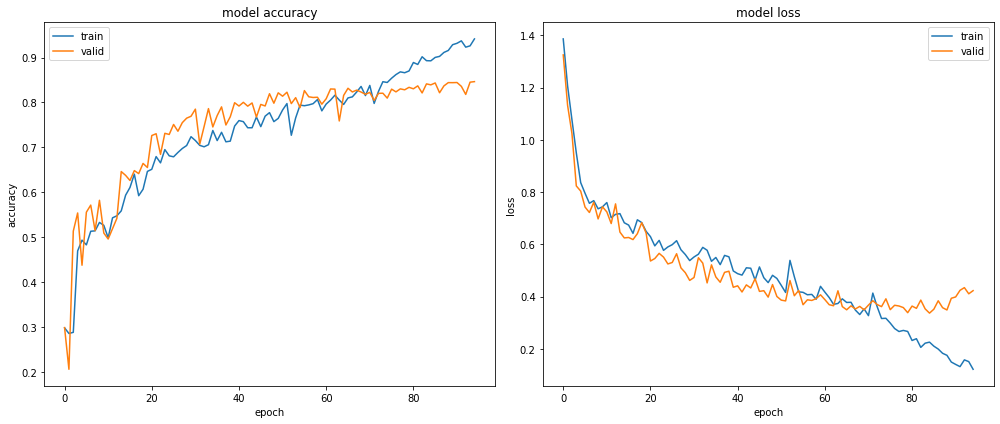

In [ ]:
# Show history


show_graph_loss_accuracy(np.asarray(history),1)

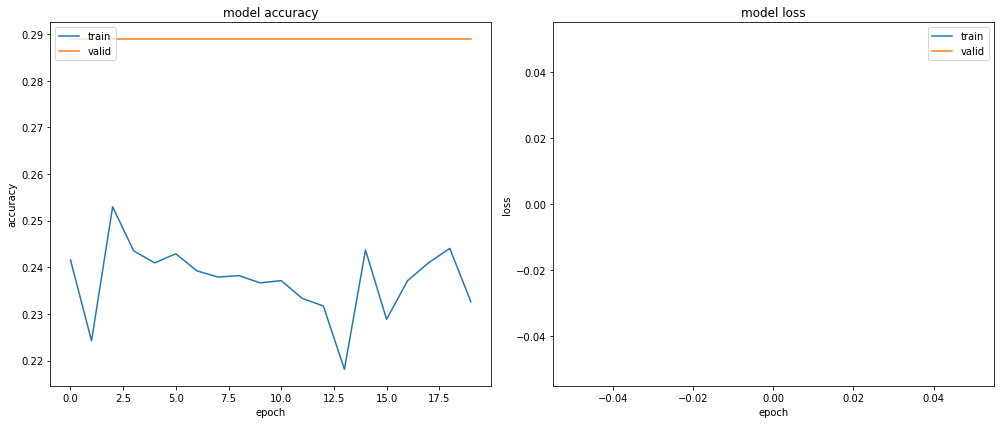

In [ ]:
# Show history

show_graph_loss_accuracy(np.asarray(history_CNN_model_dl3p),1)



# **13. Evaluating the CNN model over training and validation data**

In [ ]:
# Functions

def Test(model, patch_test):
    result = model.predict(patch_test)
    predicted_classes = np.argmax(result, axis=-1)
    return predicted_classes

def compute_metrics(true_labels, predicted_labels):
    accuracy = 100*accuracy_score(true_labels, predicted_labels)
    f1score = 100*f1_score(true_labels, predicted_labels, average=None)
    recall = 100*recall_score(true_labels, predicted_labels, average=None)
    precision = 100*precision_score(true_labels, predicted_labels, average=None)
    return accuracy, f1score, recall, precision

In [ ]:
# load the best model (.h5 file) unet
model = load_model(root_path + best_model_filename + '.h5', compile=False)

# Test the model over training and validation data
pred_train = Test(model, x_train)
pred_valid = Test(model, x_valid)


Plotting images...


(-0.5, 255.5, 255.5, -0.5)

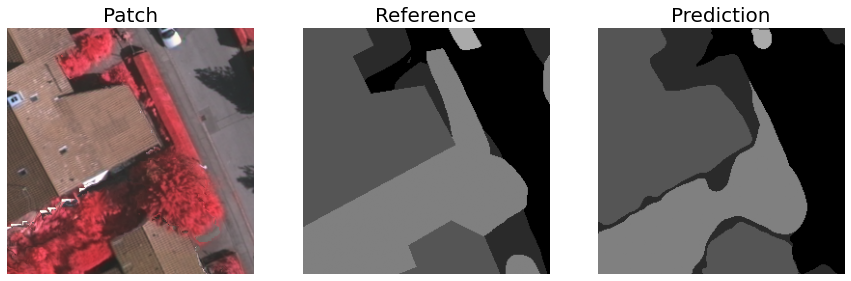

In [ ]:
# Showing the prediction for an arbitrary training patch -  unet

index = 20

print('\nPlotting images...')
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(15, 15))

ax1.imshow(x_train[index])
ax1.set_title('Patch', fontsize=20)
ax1.axis('off')

ax2.imshow( y_train[index, :, :, 0], cmap='gray', vmin=0, vmax=num_classes )
ax2.set_title('Reference', fontsize=20)
ax2.axis('off')

ax3.imshow( pred_train[index], cmap='gray', vmin=0, vmax=num_classes )
ax3.set_title('Prediction', fontsize=20)
ax3.axis('off')

In [ ]:
# load the best model (.h5 file) Deeplabv3_plus
model_dl3p = load_model(root_path + best_model_filename_dl3p + '.h5', compile=False)

# Test the model over training and validation data
pred_train_dl3p = Test(model_dl3p, x_train)
pred_valid_dl3p = Test(model_dl3p, x_valid)


Plotting images...


(-0.5, 255.5, 255.5, -0.5)

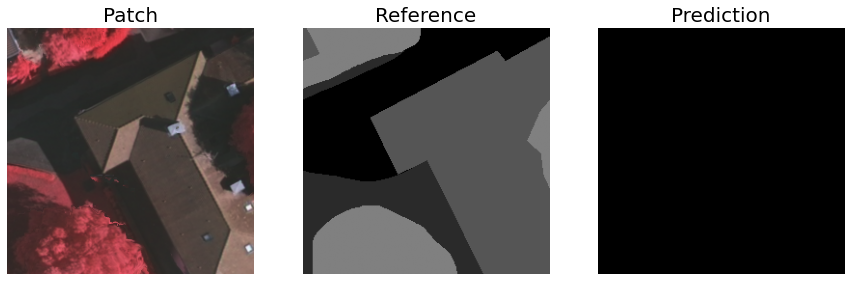

In [ ]:
# Showing the prediction for an arbitrary training patch -  Deeplabv3_plus

index = 20

print('\nPlotting images...')
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(15, 15))

ax1.imshow(x_train[index])
ax1.set_title('Patch', fontsize=20)
ax1.axis('off')

ax2.imshow( y_train[index, :, :, 0], cmap='gray', vmin=0, vmax=num_classes )
ax2.set_title('Reference', fontsize=20)
ax2.axis('off')

ax3.imshow( pred_train_dl3p[index], cmap='gray', vmin=0, vmax=num_classes )
ax3.set_title('Prediction', fontsize=20)
ax3.axis('off')

In [ ]:
# Showing the confusion matrix and accuracy metrics for the training data - unet

true_labels = np.reshape(y_train, (y_train.shape[0]* y_train.shape[1]*y_train.shape[2]))
predicted_labels = np.reshape(pred_train, (pred_train.shape[0]* pred_train.shape[1]*pred_train.shape[2]))

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
print('Confusion  matrix')
print('=================')
print(cm)

# Metrics
metrics = compute_metrics(true_labels, predicted_labels)
print('\nMetrics')
print('=======')
print('Accuracy: ', metrics[0])
print('F1score: ', metrics[1])
print('Recall: ', metrics[2])
print('Precision: ', metrics[3])

Confusion  matrix
[[1270785   52116   58742   31153     928]
 [ 116741 1171454   52653  232026      55]
 [  66272   82621 1000075    4028     467]
 [  51458  388148    7764 1557732       0]
 [   9815     269    1217     331    3534]]

Metrics
Accuracy:  81.22188486951462
F1score:  [86.77869226 71.70256986 87.96067046 81.33580759 35.07692308]
Recall:  [89.88918629 74.47596172 86.7019575  77.68841685 23.30212317]
Precision:  [83.87626718 69.12831758 89.25646905 85.34255206 70.90690209]


In [ ]:
# Showing the confusion matrix and accuracy metrics for the training data -  Deeplabv3_plus

true_labels = np.reshape(y_train, (y_train.shape[0]* y_train.shape[1]*y_train.shape[2]))
predicted_labels_dl3p = np.reshape(pred_train_dl3p, (pred_train_dl3p.shape[0]* pred_train_dl3p.shape[1]*pred_train_dl3p.shape[2]))

# Confusion Matrix
cm_dl3p = confusion_matrix(true_labels, predicted_labels_dl3p)
print('Confusion  matrix  -  Deeplabv3_plus')
print('=================')
print(cm_dl3p)

# Metrics
metrics_dl3p = compute_metrics(true_labels, predicted_labels_dl3p)
print('\nMetrics')
print('=======')
print('Accuracy: ', metrics_dl3p[0])
print('F1score: ', metrics_dl3p[1])
print('Recall: ', metrics_dl3p[2])
print('Precision: ', metrics_dl3p[3])

Confusion  matrix  -  Deeplabv3_plus
[[1431381       0       0       0       0]
 [1592299       0       0       0       0]
 [1186529       0       0       0       0]
 [1933535       0       0       0       0]
 [  16640       0       0       0       0]]

Metrics
Accuracy:  23.235256113904587
F1score:  [37.7087805  0.         0.         0.         0.       ]
Recall:  [100.   0.   0.   0.   0.]
Precision:  [23.23525611  0.          0.          0.          0.        ]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Freeing up memory

x_train = 0
y_train = 0
x_valid = 0
y_valid = 0
pred_train = 0
pred_valid = 0
true_labels = 0
predicted_labels = 0

pred_train_dl3p = 0
pred_valid_dl3p = 0
true_labels_dl3p = 0
predicted_labels_dl3p = 0




# **14. Inference (testing the CNN model)**

In [ ]:
# load the best model (.h5 file) - unet
best_model_filename = 'best_CNN_model'
model = load_model(root_path + best_model_filename + '.h5', compile=False)

In [ ]:
# load the best model (.h5 file) - best_CNN_model_dl3p
best_model_filename_dl3p = 'best_CNN_model_dl3p'
model_dl3p = load_model(root_path + best_model_filename_dl3p + '.h5', compile=False)

In [ ]:
# Constants

# patch_size defines the measures (spatial dimensions) of the patch.
# Working with square patches (H = W). Therefore, a scalar variable is enough.
patch_test_size = patch_size
patch_test_stride = 128


In [ ]:
# Extracting test patches



print(image_test.shape)
print(labels_test.shape)
print(patch_test_size)
print(patch_test_stride)


x_patches_test, y_patches_test = extract_patches(image_test, labels_test, patch_test_size, patch_test_stride, True)



print( "Number of patches: %d %s " % ( x_patches_test.shape[0], x_patches_test.shape[1:] ) )
print( "Number of labeled references: %d %s " % ( y_patches_test.shape[0], y_patches_test.shape[1:] ) )

(2558, 2818, 3)
(2558, 2818)
256
128
Image dimensions: (2558, 2818, 3)
Reference dimensions: (2558, 2818)
Number of patches: 418 (256, 256, 3) 
Number of labeled references: 418 (256, 256) 


# **15. Prediction over test patches**

In [ ]:
# Test the model over test patches - unet

pred_test_patches = Test(model, x_patches_test)
print(pred_test_patches.shape)

(418, 256, 256)


In [ ]:
 # Test the model over test patches - best_CNN_model_dl3p
pred_test_patches_dl3p = Test(model_dl3p, x_patches_test)
print(pred_test_patches_dl3p.shape)

(418, 256, 256)



Plotting images...


(-0.5, 255.5, 255.5, -0.5)

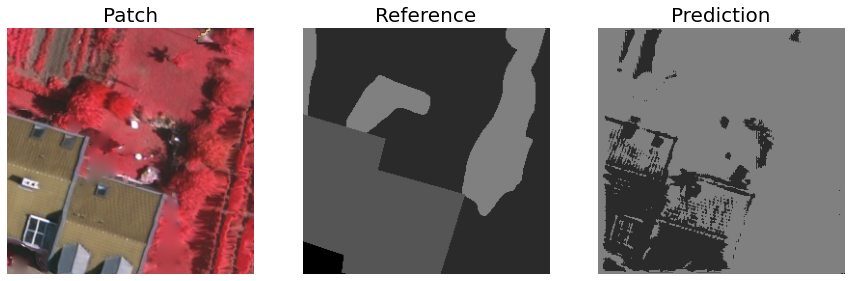

In [ ]:
# Showing prediction result for an arbitrary test patch - unet

index = 20

print('\nPlotting images...')
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(15, 15))

ax1.imshow(x_patches_test[index])
ax1.set_title('Patch', fontsize=20)
ax1.axis('off')

ax2.imshow( y_patches_test[index], cmap='gray', vmin=0, vmax=num_classes )
ax2.set_title('Reference', fontsize=20)
ax2.axis('off')

ax3.imshow( pred_test_patches[index], cmap='gray', vmin=0, vmax=num_classes )
ax3.set_title('Prediction', fontsize=20)
ax3.axis('off')



Plotting images...


(-0.5, 255.5, 255.5, -0.5)

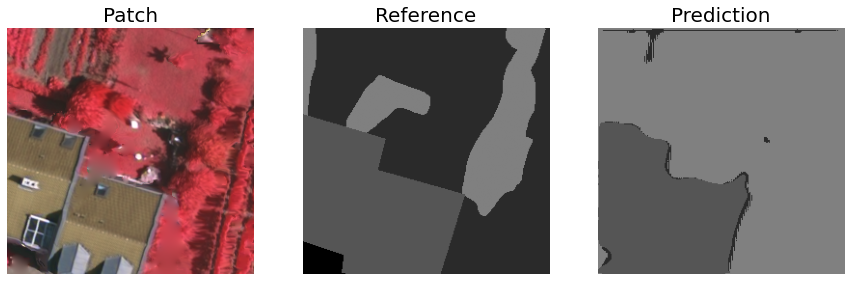

In [ ]:
# Showing prediction result for an arbitrary test patch - best_CNN_model_dl3p

index = 20

print('\nPlotting images...')
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(15, 15))

ax1.imshow(x_patches_test[index])
ax1.set_title('Patch', fontsize=20)
ax1.axis('off')

ax2.imshow( y_patches_test[index], cmap='gray', vmin=0, vmax=num_classes )
ax2.set_title('Reference', fontsize=20)
ax2.axis('off')

ax3.imshow( pred_test_patches_dl3p[index], cmap='gray', vmin=0, vmax=num_classes )
ax3.set_title('Prediction', fontsize=20)
ax3.axis('off')


In [ ]:
# Showing the confusion matrix and accuracy metrics for the test data (patches) - unet

true_labels = np.reshape(y_patches_test, (y_patches_test.shape[0]* y_patches_test.shape[1]*y_patches_test.shape[2]))
predicted_labels = np.reshape(pred_test_patches, (pred_test_patches.shape[0]* pred_test_patches.shape[1]*pred_test_patches.shape[2]))

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
print('Confusion  matrix')
print('=================')
print(cm)

# Metrics
metrics = compute_metrics(true_labels, predicted_labels)
print('\nMetrics')
print('=======')
print('Accuracy: ', metrics[0])
print('F1score: ', metrics[1])
print('Recall: ', metrics[2])
print('Precision: ', metrics[3])

Confusion  matrix
[[      0 3436575    1553 1558640       0]
 [      0 1660451     295 7809922       0]
 [      0 3089346    1030 1781925       0]
 [      0  283774      22 7665707       0]
 [      0   87871      94   16843       0]]

Metrics
Accuracy:  34.04822828667016
F1score:  [0.00000000e+00 1.84201011e+01 4.22538534e-02 5.72440627e+01
 0.00000000e+00]
Recall:  [0.00000000e+00 1.75325648e+01 2.11399090e-02 9.64300158e+01
 0.00000000e+00]
Precision:  [ 0.         19.40228677 34.40213761 40.70350948  0.        ]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Showing the confusion matrix and accuracy metrics for the test data (patches) - best_CNN_model_dl3p

true_labels = np.reshape(y_patches_test, (y_patches_test.shape[0]* y_patches_test.shape[1]*y_patches_test.shape[2]))
predicted_labels_dl3p = np.reshape(pred_test_patches_dl3p, (pred_test_patches_dl3p.shape[0]* pred_test_patches_dl3p.shape[1]*pred_test_patches_dl3p.shape[2]))

# Confusion Matrix
cm_dl3p = confusion_matrix(true_labels, predicted_labels_dl3p)
print('Confusion  matrix - dl3p')
print('=================')
print(cm_dl3p)

# Metrics
metrics_dl3p = compute_metrics(true_labels, predicted_labels_dl3p)
print('\nMetrics')
print('=======')
print('Accuracy: ', metrics_dl3p[0])
print('F1score: ', metrics_dl3p[1])
print('Recall: ', metrics_dl3p[2])
print('Precision: ', metrics_dl3p[3])

Confusion  matrix - dl3p
[[   8580  220164 3321881 1446143       0]
 [   1554  462020 1231935 7775159       0]
 [   2498  298426 4172174  399203       0]
 [    121   91664   87485 7770233       0]
 [    177    3216   94897    6518       0]]

Metrics
Accuracy:  45.312788383812425
F1score:  [ 0.34253562  8.7618638  60.5510921  61.31145209  0.        ]
Recall:  [ 0.17171099  4.87843096 85.63046495 97.74489047  0.        ]
Precision:  [66.35730858 42.95902333 46.83430373 44.66355499  0.        ]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# **16. Mosaic of the test patches predictions**

In [ ]:
# Assembling mosaic of the test patches predictions - unet

pred_test_mosaic = np.zeros(labels_test.shape)
patch_test_overlap = patch_test_stride/patch_test_size



# Image positions
x = y = 0
xmax, ymax = labels_test.shape 

# Patch positions
pi = patch_test_size//2 - int(patch_test_size*patch_test_overlap**2)
pf = patch_test_size//2 + int(patch_test_size*patch_test_overlap**2)
 
for patch in pred_test_patches:
  if y==0: ypi = 0 
  else: ypi = pi
  if y+pf+patch_test_stride>ymax: ypf = ymax-y-2
  else: ypf = pf
  if x==0: xpi = 0 
  else: xpi = pi
  if x+pf+patch_test_stride>xmax: xpf = xmax-x 
  else: xpf = pf

  pred_test_mosaic[x+xpi:x+xpf,y+ypi:y+ypf] = patch[xpi:xpf,ypi:ypf]

  y += patch_test_stride
  if y+patch_test_stride >= ymax:
    x += patch_test_stride
    y = 0


In [ ]:
# Assembling mosaic of the test patches predictions - best_CNN_model_dl3p

pred_test_mosaic_dl3p = np.zeros(labels_test.shape)
patch_test_overlap = patch_test_stride/patch_test_size



# Image positions
x = y = 0
xmax, ymax = labels_test.shape 

# Patch positions
pi = patch_test_size//2 - int(patch_test_size*patch_test_overlap**2)
pf = patch_test_size//2 + int(patch_test_size*patch_test_overlap**2)
 
for patch in pred_test_patches_dl3p:
  if y==0: ypi = 0 
  else: ypi = pi
  if y+pf+patch_test_stride>ymax: ypf = ymax-y-2
  else: ypf = pf
  if x==0: xpi = 0 
  else: xpi = pi
  if x+pf+patch_test_stride>xmax: xpf = xmax-x 
  else: xpf = pf

  pred_test_mosaic_dl3p[x+xpi:x+xpf,y+ypi:y+ypf] = patch[xpi:xpf,ypi:ypf]

  y += patch_test_stride
  if y+patch_test_stride >= ymax:
    x += patch_test_stride
    y = 0


Plotting images...


(-0.5, 2817.5, 2557.5, -0.5)

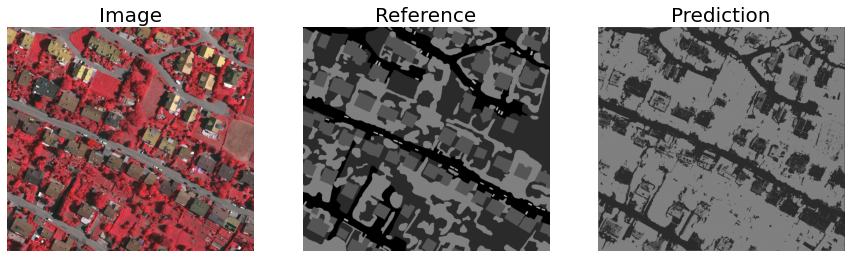

In [ ]:
# Showing prediction results mosaic - unet

print('\nPlotting images...')
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(15, 15))

ax1.imshow( image_test )
ax1.set_title('Image', fontsize=20)
ax1.axis('off')

ax2.imshow( labels_test, cmap='gray', vmin=0, vmax=num_classes )
ax2.set_title('Reference', fontsize=20)
ax2.axis('off')

ax3.imshow( pred_test_mosaic, cmap='gray', vmin=0, vmax=num_classes )
ax3.set_title('Prediction', fontsize=20)
ax3.axis('off')



Plotting images...


(-0.5, 2817.5, 2557.5, -0.5)

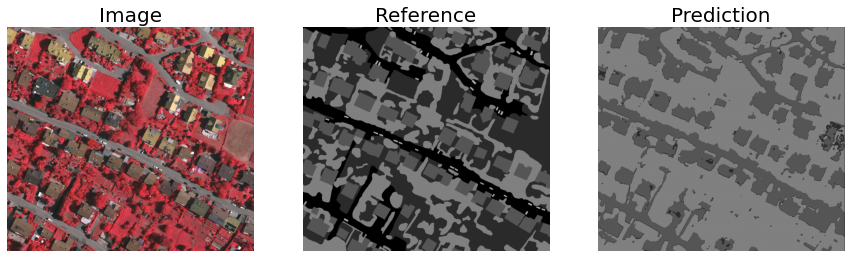

In [ ]:
# Showing prediction results mosaic - best_CNN_model_dl3p

print('\nPlotting images...')
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(15, 15))

ax1.imshow( image_test )
ax1.set_title('Image', fontsize=20)
ax1.axis('off')

ax2.imshow( labels_test, cmap='gray', vmin=0, vmax=num_classes )
ax2.set_title('Reference', fontsize=20)
ax2.axis('off')

ax3.imshow( pred_test_mosaic_dl3p, cmap='gray', vmin=0, vmax=num_classes )
ax3.set_title('Prediction', fontsize=20)
ax3.axis('off')


In [ ]:
# Showing the confusion matrix and accuracy metrics for the prediction results mosaic - unet

true_labels = np.reshape(labels_test, (labels_test.shape[0]*labels_test.shape[1]))
predicted_labels = np.reshape(pred_test_mosaic, (pred_test_mosaic.shape[0]*pred_test_mosaic.shape[1]))

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
print('Confusion  matrix')
print('=================')
print(cm)

# Metrics
metrics = compute_metrics(true_labels, predicted_labels)
print('\nMetrics')
print('=======')
print('Accuracy: ', metrics[0])
print('F1score: ', metrics[1])
print('Recall: ', metrics[2])
print('Precision: ', metrics[3])

Confusion  matrix
[[    401  976572       0  208251       0]
 [   3521  473252       0 2072331       0]
 [    576  840391       0  461801       0]
 [    618   78665       0 2065023       0]
 [      0   23913       0    3129       0]]

Metrics
Accuracy:  35.21808590036907
F1score:  [ 0.06737571 19.15264523  0.         59.38375874  0.        ]
Recall:  [3.38332670e-02 1.85654253e+01 0.00000000e+00 9.63026266e+01
 0.00000000e+00]
Precision:  [ 7.83815481 19.7782257   0.         42.92709647  0.        ]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Showing the confusion matrix and accuracy metrics for the prediction results mosaic - best_CNN_model_dl3p

true_labels = np.reshape(labels_test, (labels_test.shape[0]*labels_test.shape[1]))
predicted_labels_dl3p = np.reshape(pred_test_mosaic_dl3p, (pred_test_mosaic.shape[0]*pred_test_mosaic.shape[1]))

# Confusion Matrix
cm_dl3p = confusion_matrix(true_labels, predicted_labels_dl3p)
print('Confusion  matrix - dl3')
print('=================')
print(cm_dl3p)

# Metrics
metrics_dl3p = compute_metrics(true_labels, predicted_labels_dl3p)
print('\nMetrics')
print('=======')
print('Accuracy: ', metrics_dl3p[0])
print('F1score: ', metrics_dl3p[1])
print('Recall: ', metrics_dl3p[2])
print('Precision: ', metrics_dl3p[3])

Confusion  matrix - dl3
[[   1034   60330  916967  206893       0]
 [   3548  117232  340679 2087645       0]
 [    587   82249 1131292   88640       0]
 [    618   17003   23363 2103322       0]
 [      5     830   24810    1397       0]]

Metrics
Accuracy:  46.51322809749233
F1score:  [ 0.17363327  8.29447832 60.49885571 63.4275519   0.        ]
Recall:  [8.72408929e-02 4.59894928e+00 8.68375643e+01 9.80887056e+01
 0.00000000e+00]
Precision:  [17.85220994 42.22385501 46.41938755 46.86653905  0.        ]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
